# CLIP

official: https://github.com/openai/CLIP

huggingface: https://huggingface.co/docs/transformers/model_doc/clip

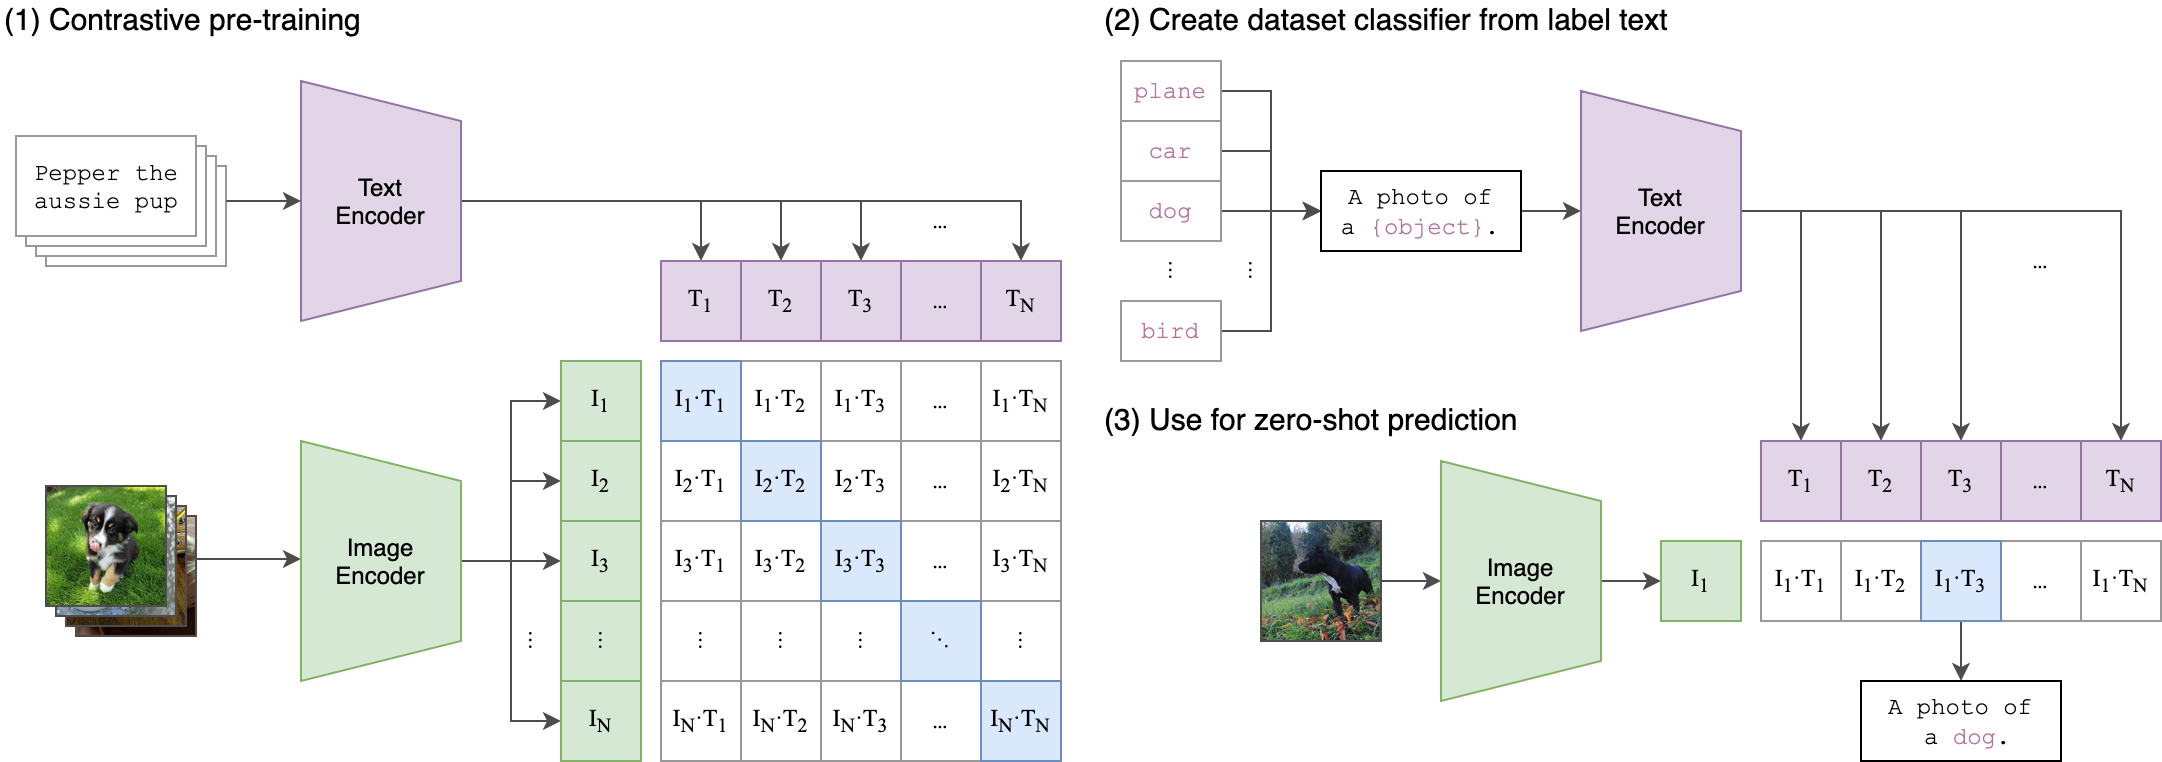

1. CLIP在訓練時使用成對的影像與文字在通過Image Encoder & Text Encoder兩個模型後分別得到影像embedding $I_{i} , 與文字embedding T_{i}$，透過對比學習的方式，最大化同一張圖片與對應的句子的相似度(即圖(1)中矩陣的藍色格子)。
2. 透過訓練好的Text Encoder建立句子的embeddings $T_{i}$
3. 將要查詢的圖片通過訓練好的Image Encoder獲得圖片embedding $I_{i}$，並與2中的所有$T_{i}$計算相似度，若$I_{1} ⋅T_{3}$為最大值，則$T_{3}$為最接近此圖之對應文字

In [ ]:
!pip install --upgrade transformers

In [ ]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
import json
from glob import glob
import os
import pandas as pd
import torch
import torch.nn.functional as F
# huggingface framework
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

## CLIP: Zero-shot classification by image-text similarity (HuggingFace)

Link: https://huggingface.co/openai/clip-vit-base-patch32

In [ ]:
# 讀取預訓練之CLIP模型(包含image, text encoder)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
# 建立圖片與文字處理器
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# 測試影像
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url = "http://farm1.staticflickr.com/73/154946881_83137159e7_z.jpg"

image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.show()

In [ ]:
# 將文字轉成tokens
inputs = processor(
    text=[
        "a photo of a cat",
        "a photo of a dog",
        "a photo of a bird"
    ],
    images=image,
    return_tensors="pt",
    padding=True
)
inputs.keys()

In [ ]:
# input_ids: 文字token ids
# "a photo of a cat"
# "a photo of a dog"
# "a photo of a bird"
inputs['input_ids']

In [ ]:
# input image tensor (BS, C, H, W)
inputs['pixel_values'].shape

In [ ]:
# 計算此圖片embedding對所有文字embedding之相似度
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image

probs = logits_per_image.softmax(dim=1)
print(probs)

## CLIP: Image Retrieval (HuggingFace)

dataset: [Pokemon](https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types)






In [ ]:
!wget https://github.com/TA-aiacademy/course_3.0/releases/download/v3.0_clip/pokemon.zip
!unzip -q pokemon.zip

In [ ]:
# 讀取所有寶可夢圖片
paths = glob("pokemon/images/*.png")
images = [Image.open(path).convert('RGB') for path in paths]

In [ ]:
# 建立CLIP模型, 前處理
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
search_sentence = 'blue turtle'

# compute image embeddings
with torch.no_grad():
    inputs = processor(text=[search_sentence],
                       images=images,
                       return_tensors="pt",
                       padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)

In [ ]:
image_embeds = outputs['image_embeds']
image_embeds.shape # (N張圖片, embedding長度)

In [ ]:
# 計算相似度
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=0)

print(logits_per_image.shape, probs.shape)

In [ ]:
# 取得相似度top k對應的圖片
def plot_top_k_images(similarities, images):
    k = 12
    values, indices = similarities.detach().cpu().squeeze().topk(k)

    top_images, top_scores, idxs = [], [], []

    for score, index in zip(values, indices):
        top_images.append(images[int(index.numpy())])
        score = score.numpy().tolist()
        top_scores.append(round(score, 3))
        idxs.append(index)

    plt.figure(figsize=(10, 15))
    for i in range(k):
        plt.subplot(4, 3, i+1)
        plt.title(f'Score: {top_scores[i]}')
        plt.imshow(top_images[i])
    plt.show()

In [ ]:
plot_top_k_images(logits_per_image, images)

## CLIP: Image to image search (Huggingface)

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# 計算所有圖片embedding作為資料庫
paths = glob("pokemon/images/*.png")
images = [Image.open(path).convert('RGB') for path in paths]

with torch.no_grad():
    inputs = processor(images=images, return_tensors="pt").to(device)
    feature_bank = model.get_image_features(**inputs)

In [ ]:
feature_bank.shape

In [ ]:
url = "https://upload.wikimedia.org/wikipedia/en/a/a6/Pok%C3%A9mon_Pikachu_art.png"
query_image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(query_image)
plt.show()
# 計算圖片embedding
inputs = processor(images=query_image, return_tensors="pt").to(device)
query_image_feature = model.get_image_features(**inputs)

In [ ]:
query_image_feature.shape

In [ ]:
# 計算query與資料庫中的相似度
similarity_scores = F.cosine_similarity(query_image_feature, feature_bank)
similarity_scores.shape

In [ ]:
plot_top_k_images(similarity_scores, images)

Using pre-compute image embeddings  for searching (Optional)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
# compute text embedding & normalized
inputs = tokenizer(["yellow mouse"],
                   padding=True,
                   return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
text_features = model.get_text_features(**inputs)
text_features_normalized = F.normalize(text_features, dim=1)

similarities = F.cosine_similarity(text_features_normalized, image_embeds)

In [ ]:
# Filter the scores and return indices
k = 12
values, indices = similarities.cpu().topk(k) # Top-K

top_images, top_scores, idxs = [], [], []

for score, index in zip(values, indices):
    top_images.append(images[int(index.numpy())])
    score = score.detach().numpy().tolist()
    top_scores.append(round(score, 3))
    idxs.append(index)

plt.figure(figsize=(10, 15))
for i in range(k):
    plt.subplot(4, 3, i+1)
    plt.title(f'Top: {i+1} Score: {top_scores[i]}')
    plt.imshow(top_images[i])
plt.show()

## Resource:



*   [multilingual-clip](https://colab.research.google.com/drive/1xO-wC_m_GNzgjIBQ4a4znvQkvDoZJvH4?usp=sharing#scrollTo=dental-friendly)
*   [image search CLIP](https://colab.research.google.com/github/deep-diver/image_search_with_natural_language/blob/main/notebooks/Image_Search_CLIP.ipynb#scrollTo=QWcZyER6NRJb)
* [Image Retrieval MRR](https://colab.research.google.com/drive/1bLVwVKpAndpEDHqjzxVPr_9nGrSbuOQd?usp=sharing#scrollTo=d1ARsGeqOhe1)

